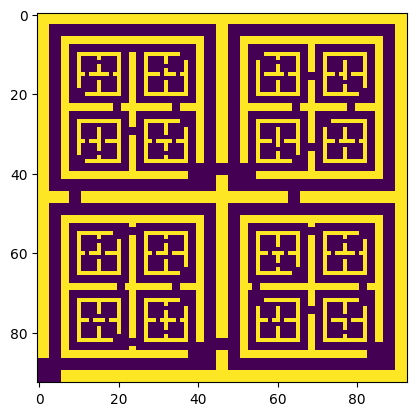

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor
from matplotlib.animation import FuncAnimation


from pyramid import create_pyramid
from continuous_maze import bfs, gen_traj, plot_traj, ContinuousGridEnvironment, TrajectoryDataset, LabelDataset
from hyperbolic_networks import HyperbolicMLP, hyperbolic_infoNCE_loss, manifold_map
from networks import StateActionEncoder, StateEncoder, infoNCE_loss

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


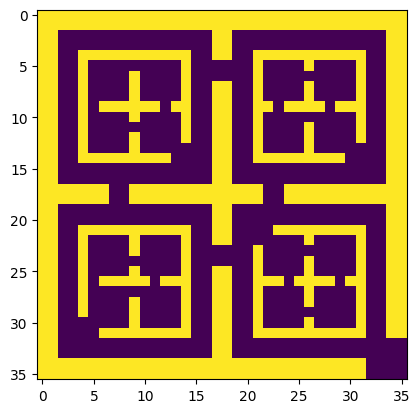

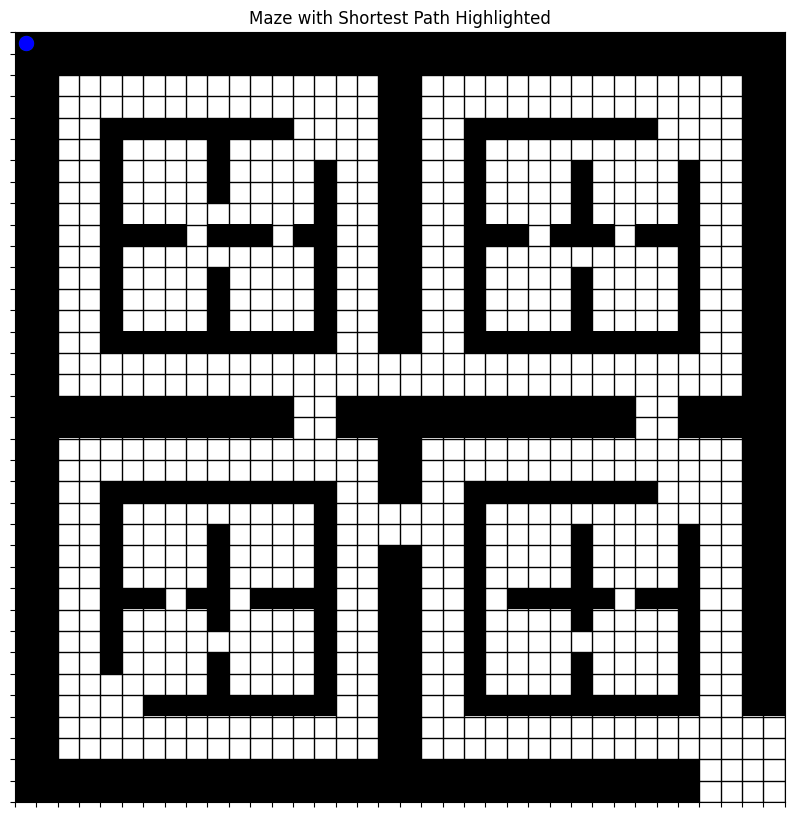

In [3]:
# define maze
# maze = np.zeros((10, 10))
# for i in range(8):
#     maze[4, i] = 1

maze = create_pyramid(np.zeros((2, 2)), 2)[0]
path = gen_traj(maze, (0, 0), (9, 9))
plot_traj(maze, [x[0] for x in path])

In [4]:
# configs
batch_size = 32
embedding_dim = 64

dataset = TrajectoryDataset(maze, 100000, embedding_dim=embedding_dim, num_negatives=10)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
def evaluate(maze, num_trials, encoder1, encoder2, manifold, max_steps=100, hyperbolic=False, eps=10., step_size=0.5, verbose=False):
    valid_indices = np.argwhere(maze == 0)
    np.random.shuffle(valid_indices)
    
    results = []
    for i in range(num_trials):
        with torch.no_grad():
            start, end = np.random.randint(0, len(valid_indices), size=2)
            start = tuple(valid_indices[start])
            end = tuple(valid_indices[end])
            
            goal = torch.tensor(end).to(torch.float32).to(device).unsqueeze(0)
            if hyperbolic:
                goal = manifold_map(goal, manifold=manifold)
            goal = encoder2(goal)
            
            # print(start)
            env = ContinuousGridEnvironment(maze, start, {})
            
            def reached(cur_pos, goal_pos):
                # print(f'cur pos: {cur_pos}')
                cur_pos = (int(cur_pos[0]), int(cur_pos[1]))
                goal_pos = (int(goal_pos[0]), int(goal_pos[1]))
                return cur_pos == goal_pos
            
            def step():
                cur_pos = env.agent_position
                if verbose:
                    print(f'cur_pos: {cur_pos}, goal: {goal}')
                activations = []
                angles = torch.linspace(0., 2 * torch.pi, 16)
                for a in angles:
                    action = torch.tensor([torch.sin(a), torch.cos(a)])
                    cur = torch.tensor([cur_pos[0], cur_pos[1], torch.sin(a), torch.cos(a)]).to(device, torch.float32)
                    if hyperbolic:
                        cur = manifold_map(cur, manifold)
                    cur = encoder1(cur)

                    # MANIFOLD EVAL
                    if hyperbolic:
                        activations.append((action, -manifold.dist(x=cur, y=goal)))
                    else:
                        activations.append((action, -torch.norm(cur - goal)))
                        
            

                best_action = activations[np.argmax([x[1].cpu() for x in activations])][0]
                angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                env.move_agent(best_action)
                # print(f'agent position: {env.agent_position}')
                
                
            def SPL(maze, start, end, num_steps, success): # Success weighted by (normalized inverse) Path Length
                if not success:
                    return 0
                else:
                    p = num_steps * step_size
                    l = len(bfs(maze, start, end))
                    return (l / max(p, l))
            
            steps = 0
            while not reached(env.agent_position, end):
                if steps > max_steps:
                    break
                step()
                steps += 1
                
            result = (not reached(env.agent_position, end), steps, SPL(maze, start, end, steps, reached(env.agent_position, end)))
            if verbose:
                print(reached(env.agent_position, end))
                print(f'start: {start}, goal: {end}, end_pos: {env.agent_position}, steps: {steps}')
                print(results)
                
            results.append(result)
    
    return results
    

In [6]:
def visualize_path(start, end, encoder_mod1, encoder_mod2, hyperbolic=False, manifold=None, max_steps=100, eps=50):
    with torch.no_grad():
        # maze.cpu()
        vec2 = None
        start = torch.tensor(start).to(device, torch.float32)
        goal = torch.tensor(end).to(device, torch.float32)
        
        if hyperbolic:
            goal = manifold_map(goal, manifold)
            
        vec2 = encoder_mod2(goal)

        env = ContinuousGridEnvironment(maze, start.cpu(), {})
        fig, ax = plt.subplots()

        def update(i):
            with torch.no_grad():
                cur_pos = env.agent_position

                activations = []
                angles = torch.linspace(0., 2 * torch.pi, 16)
                for a in angles:
                    action = torch.tensor([torch.sin(a), torch.cos(a)])
                    vec1 = torch.tensor([cur_pos[0], cur_pos[1], torch.sin(a), torch.cos(a)]).to(device, torch.float32)
                    if hyperbolic:
                        vec1 = manifold_map(vec1, manifold)
                    vec1 = encoder_mod1(vec1)

                    # MANIFOLD EVAL
                    if hyperbolic:
                        activations.append((action, -manifold.dist(x=vec1, y=vec2)))
                    else:
                        activations.append((action, -torch.norm(vec1 - vec2)))

                best_action = activations[np.argmax([x[1].cpu() for x in activations])][0]
                angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                env.move_agent(best_action)
                # print(f'agent position: {env.agent_position}')
                ax.clear()
                env.display(ax=ax)

        # Set animation display in Jupyter notebook and figure resolution
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams['figure.dpi'] = 150

        # Create the animation
        ani = FuncAnimation(fig, update, frames=max_steps, interval=max_steps, repeat=False)

    return ani

In [7]:
not True

False

In [8]:
def train(num_epochs, maze, dataloader, encoder_mod1, encoder_mod2, optimizer, hyperbolic=False, manifold=None, eval_trials=100, max_steps=100):
    print(f'is hyperbolic: {hyperbolic}')
    # Training loop
    accuracies = []
    losses = []
    failures = []
    for epoch in range(num_epochs):
        total_loss = 0
        for anchor, positive, negatives in dataloader:
            # (s,a) <-> (s)
            anchor = torch.tensor(anchor).to(device, torch.float32)
            positive = torch.tensor(positive).to(device, torch.float32)
            negatives = torch.tensor(negatives).to(device, torch.float32)
            
            if hyperbolic:
                m_anchor = manifold_map(anchor, manifold)
                m_positive = manifold_map(positive, manifold)
                m_negatives = manifold_map(negatives, manifold)
            else:
                m_anchor = anchor
                m_positive = positive
                m_negatives = negatives
            
            anchor_enc = encoder_mod1(m_anchor) # takes state, action tuple
            positive_enc = encoder_mod2(m_positive) # takes state
            negatives_enc = encoder_mod2(m_negatives)

            positive_action = anchor[:,[2,3]]
            cur_state = anchor[:,[0,1]]
            angle = torch.arctan2(anchor[:,2], anchor[:,3])

            negative_actions = (angle + torch.pi)[:,None] + (torch.rand(num_negatives)[None,:].to(device) - 0.5) * (3 * torch.pi / 2)
            negative_dirs = torch.stack([torch.sin(negative_actions), torch.cos(negative_actions)]).moveaxis(0, -1)
            # print(f'negative actions shape: {negative_actions.shape}')
            # print(negative_dirs.shape)
            negative_full = torch.cat((cur_state.unsqueeze(1).expand(-1, num_negatives, -1), negative_dirs), dim=-1).to(device)
            
            if hyperbolic:
                m_negative_full = manifold_map(negative_full, manifold)
            else:
                m_negative_full = negative_full

            # print(negative_full.shape)
            neg_action_enc = encoder_mod1(m_negative_full)
            # print(f'positive_enc: {positive_enc.shape}, anchor: {anchor_enc.shape}, neg_action_enc: {neg_action_enc.shape}')
            
            if hyperbolic:
                action_loss = hyperbolic_infoNCE_loss(positive_enc, anchor_enc, neg_action_enc, temperature, manifold=manifold)
                future_loss = hyperbolic_infoNCE_loss(anchor_enc, positive_enc, negatives_enc, temperature, manifold=manifold)
            else:
                action_loss = infoNCE_loss(positive_enc, anchor_enc, neg_action_enc, temperature, metric_type=1)
                future_loss = infoNCE_loss(anchor_enc, positive_enc, negatives_enc, temperature, metric_type=1)
            
            loss = action_loss + future_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        loss = total_loss / len(dataloader)
        evals = evaluate(maze, eval_trials, encoder_mod1, encoder_mod2, manifold, max_steps=max_steps, hyperbolic=hyperbolic)
        acc = np.mean([x[2] for x in evals])
        fail = np.mean([x[0] for x in evals])
        losses.append(loss)
        accuracies.append(acc)
        failures.append(fail)
        print(f'Epoch {epoch+1}, Loss: {loss}, SPL: {acc}, Failure %: {fail}')
    return losses, accuracies, failures
        


## Train

In [9]:
num_epochs = 8
temperature = 0.1
batch_size = 32
num_negatives = 11
# Initialize encoders
metric_type = 0
eval_type = 'dot'
manifold = PoincareBall(c=Curvature(value=0.1, requires_grad=True))

if metric_type == 1:
    eval_type = 'dist'


In [10]:
def train_opt(hyperbolic, num_epochs, max_steps, eval_trials):
    manifold = PoincareBall(c=Curvature(value=0.1, requires_grad=True))
    if hyperbolic:
        encoder1 = HyperbolicMLP(in_features=4, out_features=embedding_dim, manifold=manifold.to(device)).to(device)
        encoder2 = HyperbolicMLP(in_features=2, out_features=embedding_dim, manifold=manifold.to(device)).to(device)

        optimizer = RiemannianAdam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=0.001)
    else:
        encoder1 = StateActionEncoder(embedding_dim).to(device)
        encoder2 = StateEncoder(embedding_dim).to(device)

        optimizer = optim.Adam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=0.001)

    losses, accs, failures = train(num_epochs, maze, dataloader, encoder1, encoder2, optimizer, hyperbolic=hyperbolic, manifold=manifold, eval_trials=eval_trials, max_steps=max_steps)
    
    return losses, accs, failures, encoder1, encoder2, manifold

def plot_results(epochs, losses, accs, failures):
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot for losses
    axs[0].plot(epochs, losses, marker='o', linestyle='-', color='b')
    axs[0].set_title('Losses over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Losses')

    # Plot for accuracies
    axs[1].plot(epochs, accs, marker='o', linestyle='-', color='g')
    axs[1].set_title('Success weighted by (normalized inverse) Path Length')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Weighted Success')

    # Plot for failures
    axs[2].plot(epochs, failures, marker='o', linestyle='-', color='r')
    axs[2].set_title('Failures over Epochs')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Failures Percentage')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
losses, accs, failures, e1, e2, manifold = train_opt(hyperbolic=False, num_epochs=10, max_steps=100, eval_trials=500)

plot_results([i for i in range(len(losses))], losses, accs, failures)

is hyperbolic: False


/tmp/ipykernel_2464127/4007822106.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor = torch.tensor(anchor).to(device, torch.float32)
/tmp/ipykernel_2464127/4007822106.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive = torch.tensor(positive).to(device, torch.float32)
/tmp/ipykernel_2464127/4007822106.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negatives = torch.tensor(negatives).to(device, torch.float32)


Epoch 1, Loss: 7.015215587997437, SPL: 0.01692857142857143, Failure %: 0.982
Epoch 2, Loss: 3.7767328060150147, SPL: 0.008521298701298701, Failure %: 0.988
Epoch 3, Loss: 3.6569096253967284, SPL: 0.01820875711207142, Failure %: 0.978
Epoch 4, Loss: 3.4614475695037843, SPL: 0.011726159554730983, Failure %: 0.986
Epoch 5, Loss: 3.217497413711548, SPL: 0.020986182060650147, Failure %: 0.974
Epoch 6, Loss: 3.1309301294708254, SPL: 0.026566271518807902, Failure %: 0.962
Epoch 7, Loss: 3.0864117250061036, SPL: 0.016448484848484848, Failure %: 0.982


In [ ]:
visualize_path([5.5, 1.5], [9.5, 9.5], e1, e2, hyperbolic=False, manifold=manifold, max_steps=100)

In [ ]:
evaluate(maze, 10, e1, e2, manifold, max_steps=1000, hyperbolic=False, verbose=False)